## EDA and visuals <a id="EDA"></a>
[1. Distribution of tweets by product and sentiment](#Dist-tweets-prod)

[2. Distribution of sentiment by product](#Dist-sent-prod)

[3. Word frequencies overall](#Word-freq-overall)

[4. Word frequencies by product and valence](#Word-freq-by-prod)

[5. Termite plot of words overall, by product and valence](#termite)

In [3]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sp
%matplotlib inline

* Importing the lemmatized tweets with the sentiment values calculated to look at word frequencies and distributions

In [4]:
df = pd.read_csv('data/lemmatized_and_sentiment_tweets.csv')

In [5]:
df.head()

Unnamed: 0                                              tweet  \
0           0  ['wesley83', 'have', '3G', 'iPhone', '3', 'hrs...   
1           1  ['jessedee', 'Know', 'fludapp', 'Awesome', 'iP...   
2           2  ['swonderlin', 'not', 'wait', 'iPad', '2', 'al...   
3           3  ['sxsw', 'hope', 'year', 'festival', 't', 'cra...   
4           4  ['sxtxstate', 'great', 'stuff', 'Fri', 'SXSW',...   

             product_  emotion  \
0              iPhone        0   
1  iPad or iPhone App        1   
2                iPad        1   
3  iPad or iPhone App        0   
4              Google        1   

                                   lemmatizer_tweets  textblob_polarity  \
0  wesley83 have 3G iPhone 3 hr tweeting RISE Aus...          -0.200000   
1  jessedee Know fludapp Awesome iPad iPhone app ...           0.466667   
2  swonderlin not wait iPad 2 also should sale do...          -0.155556   
3  sxsw hope year festival t crashy this year iPh...           0.000000   
4  sxtxstate great stuff Fri SXSW Marissa Mayer G...           0.800000   

   textblob_subjectivity  vs_neg  vs_neu  vs_pos  vs_compound  
0               0.400000   0.223   0.777   0.000      -0.6486  
1               0.933333   0.000   0.528   0.472       0.9100  
2               0.288889   0.000   1.000   0.000       0.0000  
3               0.000000   0.000   0.596   0.404       0.7269  
4               0.750000   0.000   0.796   0.204       0.6249

In [6]:
df.drop(labels='Unnamed: 0', axis=1, inplace=True)

## Distribution of tweets by product <a id="Dist-tweets-prod"></a>
##### [(back to top)](#EDA)

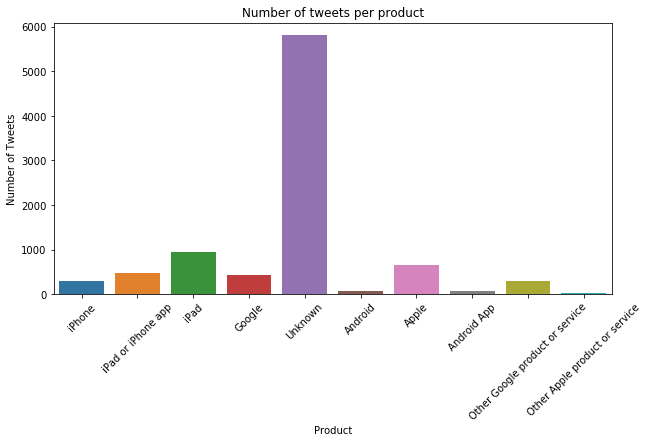

In [7]:
plt.figure(figsize=(10,5))
chart = sns.countplot(x='product_', data=df)
chart.set_xticklabels(labels=['iPhone','iPad or iPhone app','iPad','Google','Unknown',
 'Android','Apple','Android App','Other Google product or service','Other Apple product or service'], rotation=45);
chart.set_xlabel('Product');
chart.set_ylabel('Number of Tweets');
chart.set_title('Number of tweets per product');

#### Interpretation:
* Unknown product is dominating in terms of volumne - what is in this dataset if not talking about the products?
* The multitude of categories for apple products distorts the scale by products.  Combining the categories below and re-examining

In [9]:
cond_list = [df['product_'] == 'Google',
             df['product_'] == 'Other Google product or service',
            df['product_'] == 'Unknown',
            df['product_'] == 'Android',
            df['product_'] == 'Android App']
choice_list = ['Google','Google','Unknown','Android','Android']


df['product_agg'] = np.select(cond_list,choice_list, 'Apple')


In [10]:
df['product_'].value_counts()

Unknown                            5801
iPad                                946
Apple                               661
iPad or iPhone App                  470
Google                              430
iPhone                              297
Other Google product or service     293
Android App                          81
Android                              78
Other Apple product or service       35
Name: product_, dtype: int64

In [11]:
df['product_agg'].value_counts()

Unknown    5801
Apple      2409
Google      723
Android     159
Name: product_agg, dtype: int64

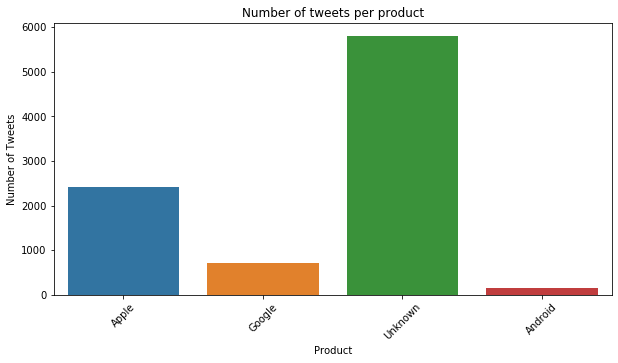

In [12]:
plt.figure(figsize=(10,5))
chart = sns.countplot(x='product_agg', data=df, )
chart.set_xticklabels(labels=['Apple','Google','Unknown','Android'], rotation=45);
chart.set_xlabel('Product');
chart.set_ylabel('Number of Tweets');
chart.set_title('Number of tweets per product');

#### Interpretation:
* Unknown still dominates - more than 2x Apple.  What are these tweets about?
* After combining Apple has more than 3x the number of tweets than Google.  
* Android is tiny fraction.

#### Calculating mean and median sentiment scores by aggregated product categories below.

In [13]:
df.head()

tweet            product_  \
0  ['wesley83', 'have', '3G', 'iPhone', '3', 'hrs...              iPhone   
1  ['jessedee', 'Know', 'fludapp', 'Awesome', 'iP...  iPad or iPhone App   
2  ['swonderlin', 'not', 'wait', 'iPad', '2', 'al...                iPad   
3  ['sxsw', 'hope', 'year', 'festival', 't', 'cra...  iPad or iPhone App   
4  ['sxtxstate', 'great', 'stuff', 'Fri', 'SXSW',...              Google   

   emotion                                  lemmatizer_tweets  \
0        0  wesley83 have 3G iPhone 3 hr tweeting RISE Aus...   
1        1  jessedee Know fludapp Awesome iPad iPhone app ...   
2        1  swonderlin not wait iPad 2 also should sale do...   
3        0  sxsw hope year festival t crashy this year iPh...   
4        1  sxtxstate great stuff Fri SXSW Marissa Mayer G...   

   textblob_polarity  textblob_subjectivity  vs_neg  vs_neu  vs_pos  \
0          -0.200000               0.400000   0.223   0.777   0.000   
1           0.466667               0.933333   0.000   0.528   0.472   
2          -0.155556               0.288889   0.000   1.000   0.000   
3           0.000000               0.000000   0.000   0.596   0.404   
4           0.800000               0.750000   0.000   0.796   0.204   

   vs_compound product_agg  
0      -0.6486       Apple  
1       0.9100       Apple  
2       0.0000       Apple  
3       0.7269       Apple  
4       0.6249      Google

In [14]:
#Creating a function to compare mean and median sentiment across the major product categories
#Provided a sentiment metric it returns the group means, ANOVA, group medians, kruskall Wallis
#and graphs the mean sentiment by product
def bivar_analyzer(sent_met):
    apple = df.loc[df['product_agg'] == 'Apple', sent_met]
    google = df.loc[df['product_agg'] == 'Google', sent_met]
    android = df.loc[df['product_agg'] == 'Android', sent_met]
    unknown = df.loc[df['product_agg'] == 'Unknown', sent_met]
    
    a = df.groupby(['product_agg'])[sent_met].mean()
    print(f'Mean {sent_met} by product')
    print(a)
    print(sp.f_oneway(apple, google, android, unknown))
    print(f'Median {sent_met} by product')
    print(df.groupby(['product_agg'])[sent_met].median())
    print(sp.kruskal(apple, google, android, unknown))
    
    plt.figure(figsize=(10,5))
    chart = sns.barplot(x=a.index,y=a, data=df, )
    chart.set_xticklabels(labels=a.index, rotation=45);
    chart.set_xlabel('Product');
    chart.set_ylabel(f'Mean {sent_met}');
    chart.set_title(f'Mean {sent_met} by product');

#### Applying bivar analyzer on textblob's polarity
* polarity ranges from -1 to 1.  Positive values are positive sentiment, negative - negative sentiment.

Mean textblob_polarity by product
product_agg
Android    0.240113
Apple      0.183993
Google     0.187189
Unknown    0.103194
Name: textblob_polarity, dtype: float64
F_onewayResult(statistic=72.66119770092284, pvalue=1.9599549661549273e-46)
Median textblob_polarity by product
product_agg
Android    0.200000
Apple      0.125000
Google     0.136364
Unknown    0.000000
Name: textblob_polarity, dtype: float64
KruskalResult(statistic=258.86652105012877, pvalue=7.906699745660572e-56)


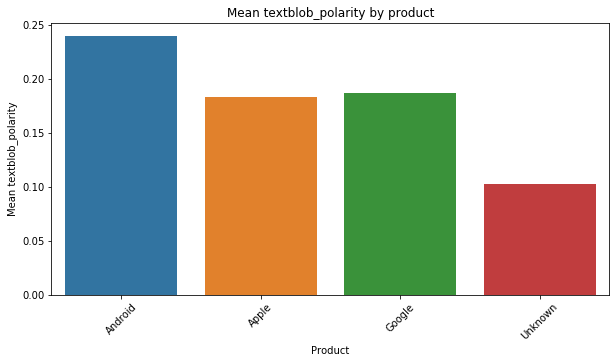

In [15]:
bivar_analyzer('textblob_polarity')

* Significantly different score. 
* Tweets without a specific product were the lowest mean polarity.
* Android, though the smallest volume of tweets had highest mean.
* Apple and Google roughly equal mean polarity.

* Given this is a mean probably better to breakout into positive and negative so as to specifically investigate those situations

#### Applying bivar analyzer on textblob's subjectivity rating
* Subjectivity rates whether the message expresses a personal opinion (1) or factual information (0).

Mean textblob_subjectivity by product
product_agg
Android    0.434576
Apple      0.403356
Google     0.400306
Unknown    0.292621
Name: textblob_subjectivity, dtype: float64
F_onewayResult(statistic=92.22118718008055, pvalue=8.661170289683443e-59)
Median textblob_subjectivity by product
product_agg
Android    0.475000
Apple      0.450000
Google     0.408333
Unknown    0.260606
Name: textblob_subjectivity, dtype: float64
KruskalResult(statistic=278.0070410776856, pvalue=5.715574003960698e-60)


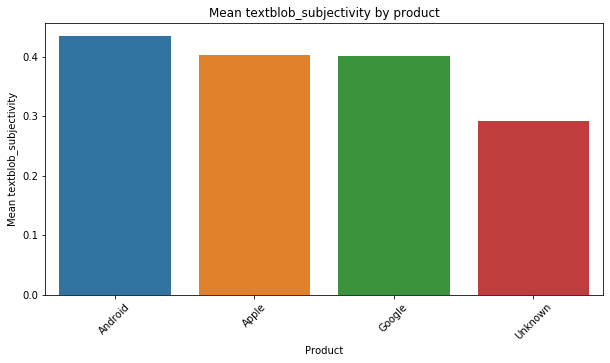

In [16]:
bivar_analyzer('textblob_subjectivity')

* Significantly different means/medians. Looking at raw means roughly equal subjectivity between named product categories and they tend to be more subjective than the unknown product.

#### Applying bivar analyzer to vander sentiment's negative rating
* Rates the percentage negative of the tweet.  Ranges from 0 to 1.

Mean vs_neg by product
product_agg
Android    0.025572
Apple      0.042899
Google     0.031533
Unknown    0.030386
Name: vs_neg, dtype: float64
F_onewayResult(statistic=15.167096905650649, pvalue=7.644024880781393e-10)
Median vs_neg by product
product_agg
Android    0.0
Apple      0.0
Google     0.0
Unknown    0.0
Name: vs_neg, dtype: float64
KruskalResult(statistic=52.39334429331721, pvalue=2.4692885033332857e-11)


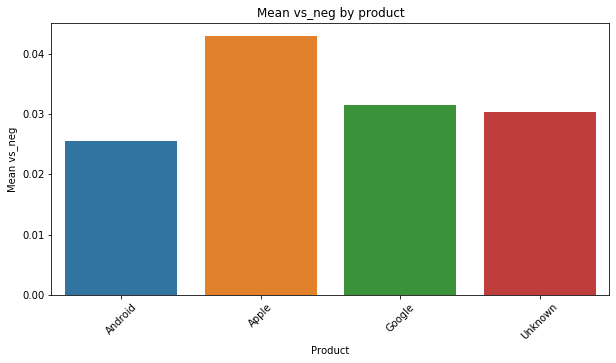

In [17]:
bivar_analyzer('vs_neg')

* Apple has the highest mean negative score - investigate by product breakdown
* Google and unknown are roughly equal
* Android, following on the polarity above, have the lowest % negative.

#### Applying bivar analyzer to vander sentiment's neutral rating
* Rates the percentage neutral of the tweet.  Ranges from 0 to 1.

Mean vs_neu by product
product_agg
Android    0.755711
Apple      0.796999
Google     0.792346
Unknown    0.868360
Name: vs_neu, dtype: float64
F_onewayResult(statistic=167.25803152036718, pvalue=1.5282622371613551e-105)
Median vs_neu by product
product_agg
Android    0.778
Apple      0.795
Google     0.796
Unknown    0.890
Name: vs_neu, dtype: float64
KruskalResult(statistic=476.93925175452216, pvalue=4.74282078425606e-103)


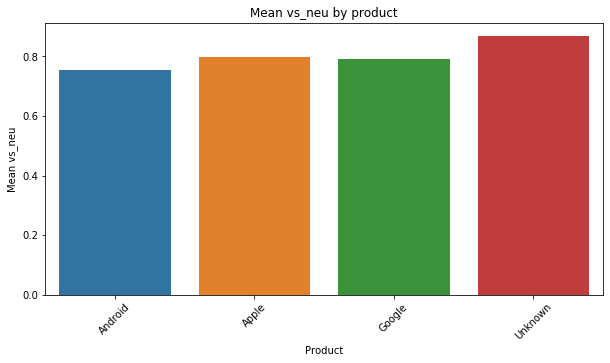

In [18]:
bivar_analyzer('vs_neu')

* Significantly different but the absolute magnitude of difference isn't that great between Android, Apple and Google.  
* Unknown products 7 points higher on average.

#### Applying bivar analyzer to vander sentiment's positive rating
* Rates the percentage positive of the tweet.  Ranges from 0 to 1.

Mean vs_pos by product
product_agg
Android    0.218717
Apple      0.160098
Google     0.176119
Unknown    0.101251
Name: vs_pos, dtype: float64
F_onewayResult(statistic=155.76177500552683, pvalue=1.9039433405980362e-98)
Median vs_pos by product
product_agg
Android    0.203
Apple      0.156
Google     0.167
Unknown    0.000
Name: vs_pos, dtype: float64
KruskalResult(statistic=440.44618466655436, pvalue=3.829970213407436e-95)


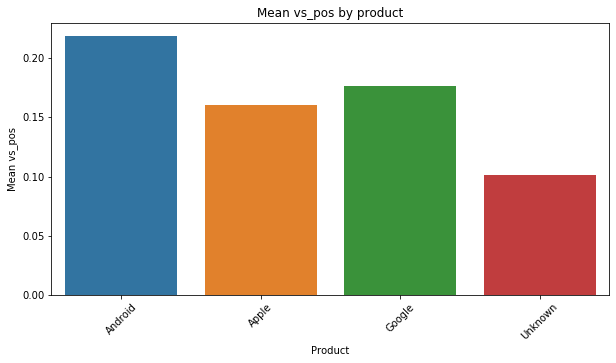

In [19]:
bivar_analyzer('vs_pos')

* Android the most positive
* Apple lowest of the main products. 
* Unknown lowest positive

#### Applying bivar analyzer to vander sentiment's compound rating
* Sum of all the lexicon ratings which have been normalized between -1 (most extreme negative) and 1 (most extreme positive)

Mean vs_compound by product
product_agg
Android    0.375961
Apple      0.259765
Google     0.310995
Unknown    0.158427
Name: vs_compound, dtype: float64
F_onewayResult(statistic=82.77447302183036, pvalue=7.873614179286613e-53)
Median vs_compound by product
product_agg
Android    0.4404
Apple      0.3182
Google     0.3818
Unknown    0.0000
Name: vs_compound, dtype: float64
KruskalResult(statistic=269.0005657016715, pvalue=5.07798680791687e-58)


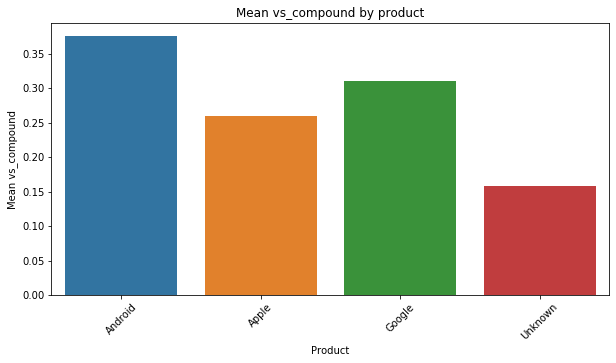

In [20]:
bivar_analyzer('vs_compound')

* Android overall most positive
* Apple least positive of major products
* Unknown has lowest mean 

## Overall impressions:
* Unknown tweets are the most neutral and least subjective - probably providing information
* Though the volume of tweets is really low Android has highest mean positivity
* Apple dominates in terms of volume but also lowest positivity and highest negativity

#### Getting all the neg, neu and pos for each product on one graph - use sns.barplot with hue - need to reshape to plot mean value by product with the hue set to the appropriate valence. 

In [21]:
a = df.groupby(['product_agg'])['vs_neg'].mean()
b = df.groupby(['product_agg'])['vs_neu'].mean()
c = df.groupby(['product_agg'])['vs_pos'].mean()

In [22]:
vs_neg = pd.DataFrame(data=a)
vs_neg['metric'] = 'VS negative'
vs_neg.rename(columns={"vs_neg":"mean_rating"},inplace=True)
vs_neg.reset_index(inplace=True)

vs_neu = pd.DataFrame(data=b)
vs_neu['metric'] = 'VS neutral'
vs_neu.rename(columns={"vs_neu":"mean_rating"},inplace=True)
vs_neu.reset_index(inplace=True)

vs_pos = pd.DataFrame(data=c)
vs_pos['metric'] = 'VS positive'
vs_pos.rename(columns={"vs_pos":"mean_rating"},inplace=True)
vs_pos.reset_index(inplace=True)

In [23]:
intermediate = vs_neg.merge(vs_neu, how='outer')

In [24]:
stacked = intermediate.merge(vs_pos, how='outer')

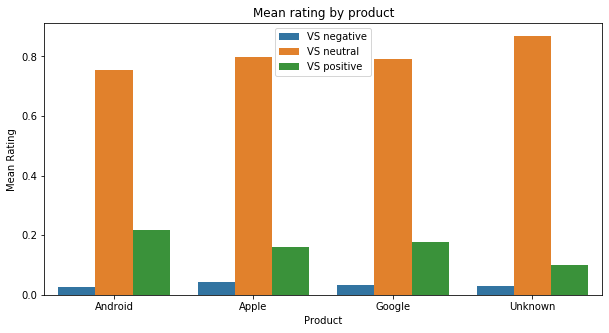

In [25]:
plt.figure(figsize=(10,5))
chart = sns.barplot(x="product_agg", y="mean_rating", hue="metric", data=stacked)
chart.set_xlabel('Product');
chart.set_ylabel('Mean Rating');
chart.set_title('Mean rating by product')
chart.legend(loc='best');

* The scale of neutral makes it hard to see what's going on with positive and negative.
* Probably won't use.

#### Generally speaking apple the most negative reviews.  
* As there were several apple subcategories will assess if there are differences in the negativity score by subcat.

In [26]:
df_apple = df.loc[df['product_agg'] == 'Apple',:]

In [27]:
df['product_'].value_counts()

Unknown                            5801
iPad                                946
Apple                               661
iPad or iPhone App                  470
Google                              430
iPhone                              297
Other Google product or service     293
Android App                          81
Android                              78
Other Apple product or service       35
Name: product_, dtype: int64

Mean VS neg by apple product
product_
Apple                             0.038233
Other Apple product or service    0.043343
iPad                              0.042960
iPad or iPhone App                0.029857
iPhone                            0.073673
Name: vs_neg, dtype: float64
F_onewayResult(statistic=14.939143039082458, pvalue=1.326413349889096e-09)
Median VS neg by apple product
product_
Apple                             0.0
Other Apple product or service    0.0
iPad                              0.0
iPad or iPhone App                0.0
iPhone                            0.0
Name: vs_neg, dtype: float64
KruskalResult(statistic=41.589478040156365, pvalue=4.903213939772419e-09)


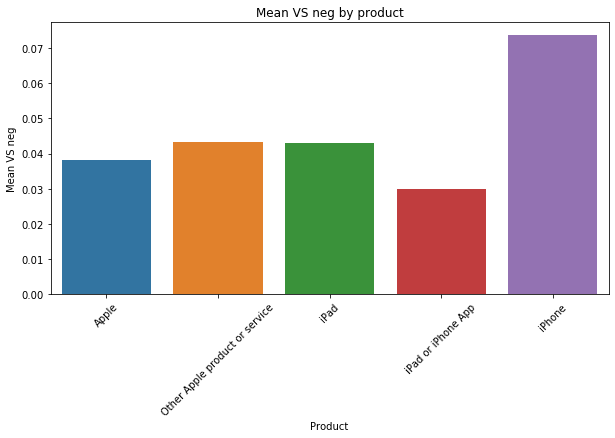

In [28]:
iPad = df_apple.loc[df_apple['product_'] == 'iPad', 'vs_neg']
apple_app = df_apple.loc[df_apple['product_'] == 'iPad or iPhone App', 'vs_neg']
iPhone = df_apple.loc[df_apple['product_'] == 'iPhone', 'vs_neg']
Other_apple = df_apple.loc[df_apple['product_'] == 'Other Apple product or service', 'vs_neg']

a = df_apple.groupby(['product_'])['vs_neg'].mean()
print('Mean VS neg by apple product')
print(a)
print(sp.f_oneway(iPad, apple_app, iPhone, Other_apple))
print('Median VS neg by apple product')
print(df_apple.groupby(['product_'])['vs_neg'].median())
print(sp.kruskal(iPad, apple_app, iPhone, Other_apple))

plt.figure(figsize=(10,5))
chart = sns.barplot(x=a.index,y=a, data=df_apple, )
chart.set_xticklabels(labels=a.index, rotation=45);
chart.set_xlabel('Product');
chart.set_ylabel('Mean VS neg');
chart.set_title('Mean VS neg by product');

* Of the apple products the most negative is the iphone.  Note the scale of the y-axis.  This is relatively true but not necessarily absolutely true.

## Distribution of Sentiment by Product <a id="Dist-sent-prod"></a>
##### [(back to top)](#EDA)

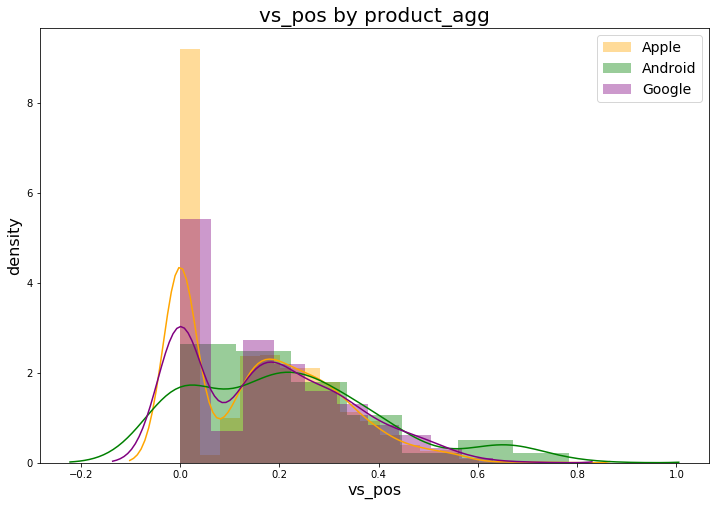

In [29]:
plt.figure(figsize=(12, 8))
ax = sns.distplot(df['vs_pos'][df['product_agg'] == 'Apple'], label='Apple', color='orange');
ax = sns.distplot(df['vs_pos'][df['product_agg'] =='Android'], label='Android', color='green');
ax = sns.distplot(df['vs_pos'][df['product_agg'] == 'Google'], label='Google', color='purple');
ax.set_title('vs_pos by product_agg', fontsize=20);
ax.set_ylabel('density', fontsize=16);
ax.set_xlabel('vs_pos', fontsize=16);
ax.legend(prop=dict(size=14));

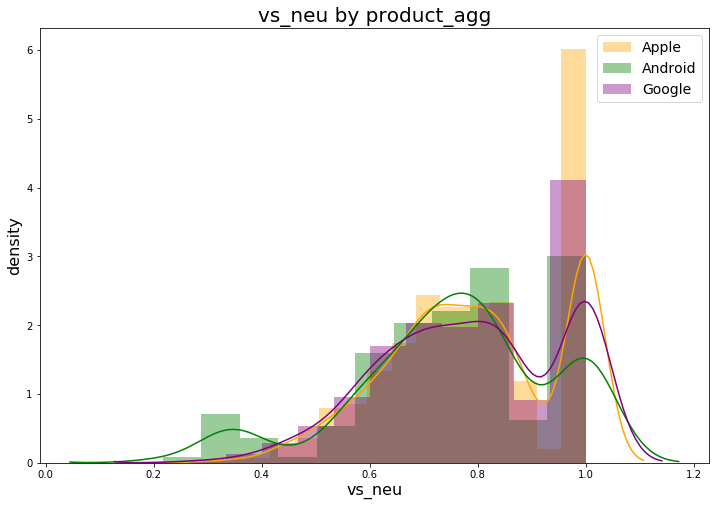

In [30]:
plt.figure(figsize=(12, 8))
ax = sns.distplot(df['vs_neu'][df['product_agg'] == 'Apple'], label='Apple', color='orange');
ax = sns.distplot(df['vs_neu'][df['product_agg'] =='Android'], label='Android', color='green');
ax = sns.distplot(df['vs_neu'][df['product_agg'] == 'Google'], label='Google', color='purple');
ax.set_title('vs_neu by product_agg', fontsize=20);
ax.set_ylabel('density', fontsize=16);
ax.set_xlabel('vs_neu', fontsize=16);
ax.legend(prop=dict(size=14));

In [36]:
df.vs_neg.describe()

count    9092.000000
mean        0.033709
std         0.078829
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.634000
Name: vs_neg, dtype: float64

RuntimeError: Selected KDE bandwidth is 0. Cannot estiamte density.

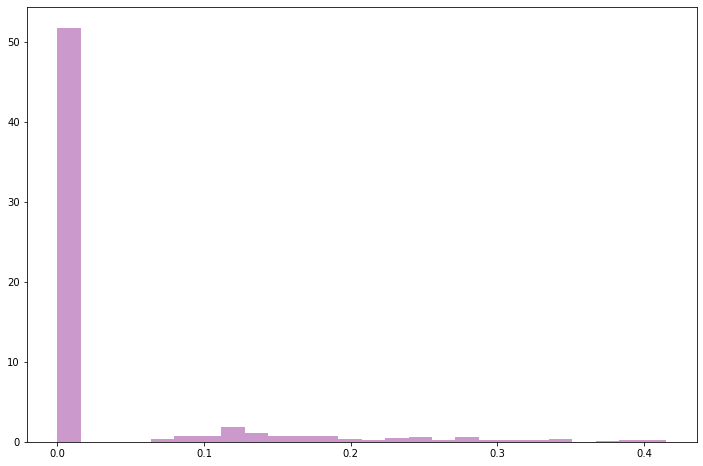

In [34]:
plt.figure(figsize=(12, 8))
ax = sns.distplot(df['vs_neg'][df['product_agg'] == 'Apple'], label='Apple', color='orange');
ax = sns.distplot(df['vs_neg'][df['product_agg'] =='Android'], label='Android', color='green');
ax = sns.distplot(df['vs_neg'][df['product_agg'] == 'Google'], label='Google', color='purple');
ax.set_title('vs_neg by product_agg', fontsize=20);
ax.set_ylabel('density', fontsize=16);
ax.set_xlabel('vs_neg', fontsize=16);
ax.legend(prop=dict(size=14));

## Word counts overall <a id="Word-freq-overall"></a>
##### [(back to top)](#EDA)

There was something going on with the format of previous tokenization and lemmatization - couldn't get the column into a flat list for counting.  Here taking the original tweet column and merging with the dataset with the valences and aggregated product categories for subsetting.  Function below includes tokenization, stop word removal, casing and lemmatization.

In [27]:
df_original = pd.read_csv('data/tweets.csv', encoding = "ISO-8859-1")
df_original.tail()

tweet_text  \
9088                      Ipad everywhere. #SXSW {link}   
9089  Wave, buzz... RT @mention We interrupt your re...   
9090  Google's Zeiger, a physician never reported po...   
9091  Some Verizon iPhone customers complained their...   
9092  Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...   

     emotion_in_tweet_is_directed_at  \
9088                            iPad   
9089                             NaN   
9090                             NaN   
9091                             NaN   
9092                             NaN   

     is_there_an_emotion_directed_at_a_brand_or_product  
9088                                   Positive emotion  
9089                 No emotion toward brand or product  
9090                 No emotion toward brand or product  
9091                 No emotion toward brand or product  
9092                 No emotion toward brand or product

In [28]:
# rename columns
df_original.rename(columns ={'tweet_text': 'tweet_original'}, 
                   inplace = True)

In [29]:
df_tweet = df_original['tweet_original']
df_tweet.dropna(inplace=True)

In [30]:
pd.options.display.max_rows = 9100

In [31]:
df_original['tweet_original']

0       .@wesley83 I have a 3G iPhone. After 3 hrs twe...
1       @jessedee Know about @fludapp ? Awesome iPad/i...
2       @swonderlin Can not wait for #iPad 2 also. The...
3       @sxsw I hope this year's festival isn't as cra...
4       @sxtxstate great stuff on Fri #SXSW: Marissa M...
5       @teachntech00 New iPad Apps For #SpeechTherapy...
7       #SXSW is just starting, #CTIA is around the co...
8       Beautifully smart and simple idea RT @madebyma...
9       Counting down the days to #sxsw plus strong Ca...
10      Excited to meet the @samsungmobileus at #sxsw ...
11      Find &amp; Start Impromptu Parties at #SXSW Wi...
12      Foursquare ups the game, just in time for #SXS...
13      Gotta love this #SXSW Google Calendar featurin...
14      Great #sxsw ipad app from @madebymany: http://...
15      haha, awesomely rad iPad app by @madebymany ht...
16      Holler Gram for iPad on the iTunes App Store -...
17      I just noticed DST is coming this weekend. How...
18      Just a

In [32]:
df_full = df.merge(df_tweet, left_index=True, right_index=True)

In [33]:
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import string, re
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [34]:
## setting stopwords and punctuations
stop_words=stopwords.words("english")
stop_words += list(string.punctuation)
stop_words += ['...','u','w','2',"i'm",'via',"we're",'6','3','hey']
# print(stop_words)
sw_set = set(stop_words)
# sw_set

In [35]:
def process_tweet(tweet):
    tokenizer = RegexpTokenizer(r"(iPad\s2|[a-zA-Z0-9-]+'?\w+)")

    tokens = tokenizer.tokenize(tweet)
    sw_removed = [token.lower().replace(" ","") for token in tokens if token.lower() not in sw_set]
    return sw_removed

In [36]:
#I want to get word counts for lots of subsets of the data (by product and valence)
#input should be the original df['tweet'] already subset
#it's df_full['tweet_original']
def word_count_func(data):
    #using the process_tweet function to tokenize, lower and remove stopwords
    process_data = list(map(process_tweet, data))
    
    #lemmatizing words
    from nltk.stem import WordNetLemmatizer 
      
    #instantiating
    lemmatizer = WordNetLemmatizer() 

    #process_data is a list of lists - here looping over the lists and then the words in the list
    lemmatizer_tweets=[]
    for l in process_data:
        new_row = []
        for w in l:
            new_row.append(lemmatizer.lemmatize(w))
        lemmatizer_tweets.append(new_row)   
    
    #This is more descriptive info - calculating the unique vocab of the subset
    overall_lem_vocab = set()
    for tweet in lemmatizer_tweets:
        overall_lem_vocab.update(tweet)
    print(f'Overall vocab of subset: {len(overall_lem_vocab)}')

    #Flattening (going from a list of lists to one single list) the lemmatized tweets for freq
    flat_lemmatizer_tweets = [item for sublist in lemmatizer_tweets for item in sublist]
    
    #applying nltk freqdist function to the flat list
    lem_freq = FreqDist(flat_lemmatizer_tweets)
    print('30 most common words in subset:')
    print(lem_freq.most_common(30))
    
    #returning normalized word freq because there are different N's
    total_words = sum(lem_freq.values())
    top_30 = lem_freq.most_common(30)
    print("Word \t\t Normalized Frequency")
    print()
    for word in top_30:
        normalized_frequency = word[1]/total_words
        print("{} \t\t {:.4}".format(word[0], normalized_frequency))
        
    #Creating word clouds - input is a dict with key word value num of occurences 
    word_dict = dict(top_30)
    from wordcloud import WordCloud
    wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(word_dict)
    
    # Display the generated image w/ matplotlib:

    plt.figure(figsize=(10,10), facecolor='k')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

Overall vocab of subset: 9225
30 most common words in subset:
[('sxsw', 9601), ('mention', 7124), ('link', 4323), ('rt', 2968), ('google', 2465), ('apple', 2230), ('quot', 1696), ('ipad', 1576), ('iphone', 1571), ('store', 1519), ('ipad2', 1370), ('new', 1090), ('austin', 958), ('amp', 836), ('app', 821), ('launch', 691), ('circle', 691), ('social', 649), ('android', 593), ('today', 574), ('network', 474), ('get', 455), ('line', 444), ('pop-up', 422), ('party', 401), ('free', 387), ('called', 361), ('mobile', 346), ('sxswi', 342), ('time', 305)]
Word 		 Normalized Frequency

sxsw 		 0.08633
mention 		 0.06406
link 		 0.03887
rt 		 0.02669
google 		 0.02217
apple 		 0.02005
quot 		 0.01525
ipad 		 0.01417
iphone 		 0.01413
store 		 0.01366
ipad2 		 0.01232
new 		 0.009802
austin 		 0.008615
amp 		 0.007518
app 		 0.007383
launch 		 0.006214
circle 		 0.006214
social 		 0.005836
android 		 0.005332
today 		 0.005162
network 		 0.004262
get 		 0.004091
line 		 0.003993
pop-up 		 0.003795


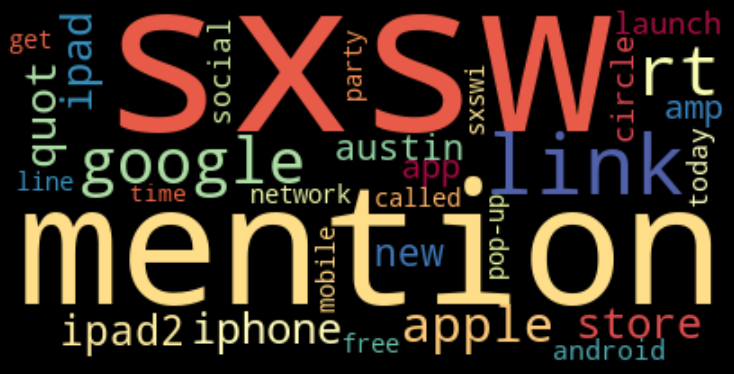

In [37]:
data1 = df_full['tweet_original']
word_count_func(data1)

## Word frequencies by Product and Valence <a id="Word-freq-by-prod"></a>
##### [(back to top)](#EDA)

In [38]:
df_full['product_agg'].value_counts()

Unknown    5801
Apple      2409
Google      723
Android     158
Name: product_agg, dtype: int64

Overall vocab of subset: 4680
30 most common words in subset:
[('sxsw', 2551), ('mention', 1756), ('link', 1076), ('rt', 684), ('apple', 664), ('google', 499), ('ipad', 482), ('iphone', 457), ('store', 435), ('ipad2', 420), ('quot', 413), ('austin', 269), ('app', 251), ('new', 230), ('amp', 192), ('android', 156), ('line', 131), ('get', 127), ('pop-up', 125), ('launch', 117), ('free', 113), ('today', 113), ('social', 102), ('party', 100), ('like', 98), ('circle', 97), ('time', 88), ('win', 88), ('one', 87), ('temporary', 79)]
Word 		 Normalized Frequency

sxsw 		 0.08838
mention 		 0.06084
link 		 0.03728
rt 		 0.0237
apple 		 0.023
google 		 0.01729
ipad 		 0.0167
iphone 		 0.01583
store 		 0.01507
ipad2 		 0.01455
quot 		 0.01431
austin 		 0.00932
app 		 0.008696
new 		 0.007968
amp 		 0.006652
android 		 0.005405
line 		 0.004539
get 		 0.0044
pop-up 		 0.004331
launch 		 0.004053
free 		 0.003915
today 		 0.003915
social 		 0.003534
party 		 0.003465
like 		 0.003395
circle 		 0.00

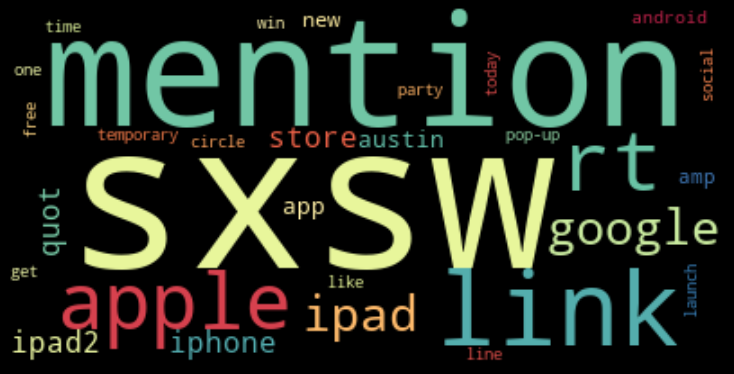

In [39]:
data_apple = df_full.loc[df_full['product_agg'] == 'Apple','tweet_original']
word_count_func(data_apple)

Overall vocab of subset: 864
30 most common words in subset:
[('sxsw', 166), ('mention', 126), ('link', 67), ('rt', 40), ('google', 38), ('iphone', 34), ('apple', 33), ('android', 31), ('app', 30), ('ipad', 27), ('quot', 25), ('store', 19), ('new', 18), ('austin', 16), ('amp', 15), ('today', 12), ('ipad2', 10), ('party', 9), ('pop-up', 9), ('get', 8), ('circle', 8), ('people', 7), ('free', 7), ('launch', 7), ('check', 7), ('awesome', 6), ('apps', 6), ('think', 6), ('love', 6), ('team', 6)]
Word 		 Normalized Frequency

sxsw 		 0.08605
mention 		 0.06532
link 		 0.03473
rt 		 0.02074
google 		 0.0197
iphone 		 0.01763
apple 		 0.01711
android 		 0.01607
app 		 0.01555
ipad 		 0.014
quot 		 0.01296
store 		 0.00985
new 		 0.009331
austin 		 0.008294
amp 		 0.007776
today 		 0.006221
ipad2 		 0.005184
party 		 0.004666
pop-up 		 0.004666
get 		 0.004147
circle 		 0.004147
people 		 0.003629
free 		 0.003629
launch 		 0.003629
check 		 0.003629
awesome 		 0.00311
apps 		 0.00311
think 		 0

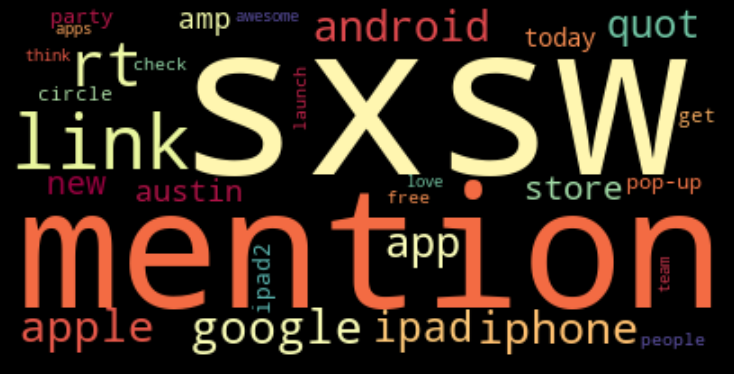

In [40]:
data_android = df_full.loc[df_full['product_agg'] == 'Android','tweet_original']
word_count_func(data_android)

Overall vocab of subset: 2269
30 most common words in subset:
[('sxsw', 749), ('mention', 536), ('google', 334), ('link', 330), ('rt', 230), ('quot', 163), ('apple', 126), ('ipad', 117), ('new', 106), ('iphone', 100), ('store', 90), ('circle', 88), ('social', 82), ('amp', 81), ('launch', 71), ('ipad2', 68), ('network', 65), ('austin', 63), ('app', 59), ('today', 55), ('mobile', 50), ('called', 49), ('map', 46), ('major', 45), ('party', 43), ('mayer', 39), ('marissa', 35), ('line', 35), ('get', 32), ('sxswi', 30)]
Word 		 Normalized Frequency

sxsw 		 0.08331
mention 		 0.05962
google 		 0.03715
link 		 0.0367
rt 		 0.02558
quot 		 0.01813
apple 		 0.01401
ipad 		 0.01301
new 		 0.01179
iphone 		 0.01112
store 		 0.01001
circle 		 0.009788
social 		 0.00912
amp 		 0.009009
launch 		 0.007897
ipad2 		 0.007563
network 		 0.007229
austin 		 0.007007
app 		 0.006562
today 		 0.006117
mobile 		 0.005561
called 		 0.00545
map 		 0.005116
major 		 0.005005
party 		 0.004783
mayer 		 0.004338


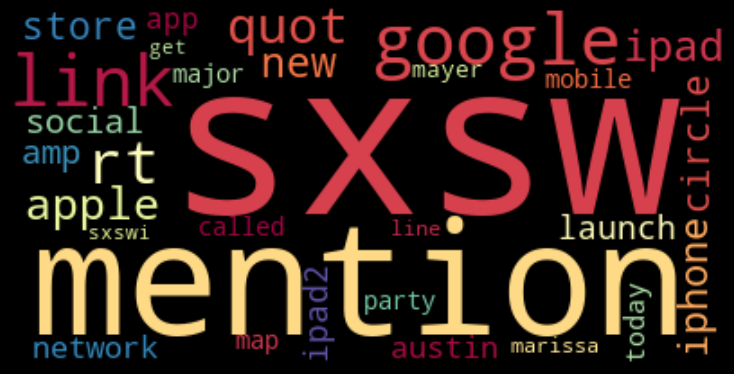

In [41]:
data_google = df_full.loc[df_full['product_agg'] == 'Google','tweet_original']
word_count_func(data_google)

Overall vocab of subset: 7460
30 most common words in subset:
[('sxsw', 6135), ('mention', 4706), ('link', 2850), ('rt', 2014), ('google', 1594), ('apple', 1407), ('quot', 1095), ('iphone', 980), ('store', 975), ('ipad', 950), ('ipad2', 872), ('new', 736), ('austin', 610), ('amp', 548), ('circle', 498), ('launch', 496), ('app', 481), ('social', 460), ('today', 394), ('android', 381), ('network', 340), ('get', 288), ('line', 273), ('pop-up', 270), ('called', 259), ('free', 250), ('party', 249), ('sxswi', 232), ('mobile', 225), ('major', 216)]
Word 		 Normalized Frequency

sxsw 		 0.0859
mention 		 0.06589
link 		 0.0399
rt 		 0.0282
google 		 0.02232
apple 		 0.0197
quot 		 0.01533
iphone 		 0.01372
store 		 0.01365
ipad 		 0.0133
ipad2 		 0.01221
new 		 0.0103
austin 		 0.008541
amp 		 0.007673
circle 		 0.006973
launch 		 0.006945
app 		 0.006735
social 		 0.006441
today 		 0.005516
android 		 0.005334
network 		 0.00476
get 		 0.004032
line 		 0.003822
pop-up 		 0.00378
called 		 0.0

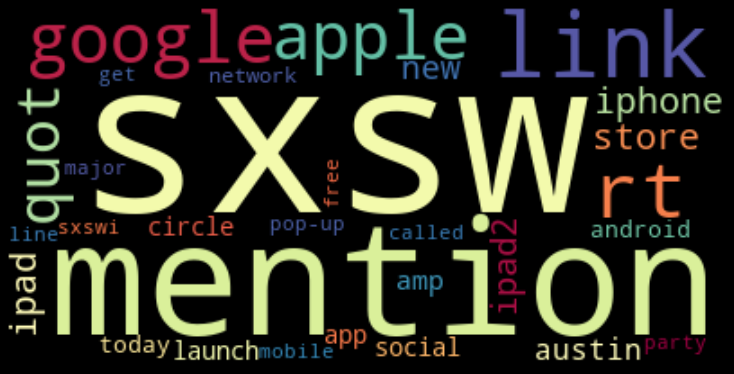

In [42]:
data_unknown = df_full.loc[df_full['product_agg'] == 'Unknown','tweet_original']
word_count_func(data_unknown)

## Summary of output:
At a bit of a loss how to interpret this. SXSW was the most frequent for all products - obviously tweets were from SXSW.  But there is no (eyeball level) specificity in terms. 

### Assessing word frequency for valence

In [43]:
df_full.columns

Index(['tweet', 'product_', 'emotion', 'lemmatizer_tweets',
       'textblob_polarity', 'textblob_subjectivity', 'vs_neg', 'vs_neu',
       'vs_pos', 'vs_compound', 'product_agg', 'tweet_original'],
      dtype='object')

In [44]:
df_full['vs_neg'].describe()

count    9091.000000
mean        0.033712
std         0.078833
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.634000
Name: vs_neg, dtype: float64

Overall vocab of subset: 38
30 most common words in subset:
[('sxsw', 4), ('quot', 2), ('best', 2), ('viewed', 2), ('explorer', 2), ('mayer', 1), ('showcasing', 1), ('google', 1), ('place', 1), ('hotpot', 1), ('restaurants-rating', 1), ('tool', 1), ('hello', 1), ('mobile', 1), ('advertising', 1), ('check-in', 1), ('push', 1), ('experimenting', 1), ('tinkering', 1), ('like', 1), ('ninety', 1), ('ipad', 1), ('new', 1), ('internet', 1), ('festival', 1), ('austin', 1), ('edition', 1), ('help', 1), ('keep', 1), ('track', 1)]
Word 		 Normalized Frequency

sxsw 		 0.08889
quot 		 0.04444
best 		 0.04444
viewed 		 0.04444
explorer 		 0.04444
mayer 		 0.02222
showcasing 		 0.02222
google 		 0.02222
place 		 0.02222
hotpot 		 0.02222
restaurants-rating 		 0.02222
tool 		 0.02222
hello 		 0.02222
mobile 		 0.02222
advertising 		 0.02222
check-in 		 0.02222
push 		 0.02222
experimenting 		 0.02222
tinkering 		 0.02222
like 		 0.02222
ninety 		 0.02222
ipad 		 0.02222
new 		 0.02222
internet 		 0.0

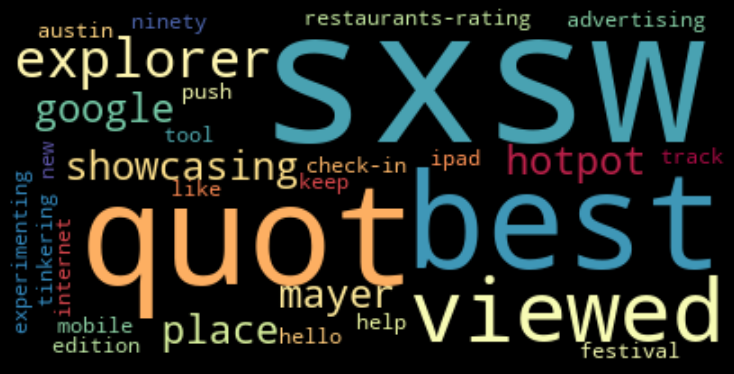

In [45]:
#arbitrarily chose vs_neg score of greater than or equal to 0.50 - corresponds to proportion
#of the tweet that is negative 
data_neg = df_full.loc[df_full['vs_neg'] >= 0.5,'tweet_original']
word_count_func(data_neg)

Overall vocab of subset: 233
30 most common words in subset:
[('sxsw', 34), ('mention', 16), ('link', 13), ('google', 7), ('iphone', 6), ('quot', 6), ('make', 4), ('new', 4), ('get', 4), ('ipad', 4), ('tool', 4), ('check', 4), ('app', 4), ('apple', 3), ('free', 3), ('itunes', 3), ('amp', 3), ('best', 3), ('good', 3), ('rt', 3), ('want', 2), ('hundred', 2), ('austin', 2), ('team', 2), ('day', 2), ('help', 2), ('meet', 2), ('map', 2), ('mobile', 2), ('software', 2)]
Word 		 Normalized Frequency

sxsw 		 0.09315
mention 		 0.04384
link 		 0.03562
google 		 0.01918
iphone 		 0.01644
quot 		 0.01644
make 		 0.01096
new 		 0.01096
get 		 0.01096
ipad 		 0.01096
tool 		 0.01096
check 		 0.01096
app 		 0.01096
apple 		 0.008219
free 		 0.008219
itunes 		 0.008219
amp 		 0.008219
best 		 0.008219
good 		 0.008219
rt 		 0.008219
want 		 0.005479
hundred 		 0.005479
austin 		 0.005479
team 		 0.005479
day 		 0.005479
help 		 0.005479
meet 		 0.005479
map 		 0.005479
mobile 		 0.005479
software 		

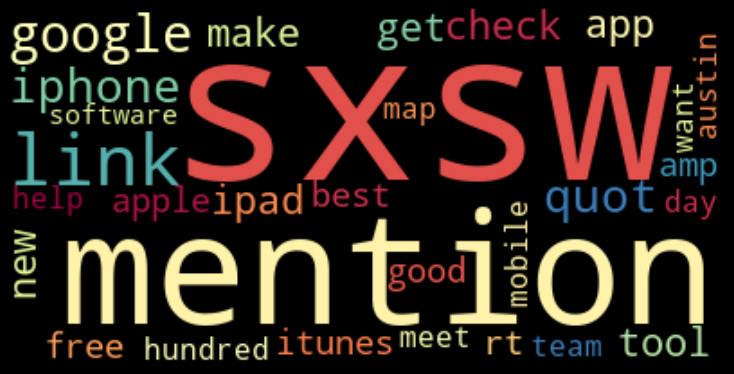

In [46]:
#0.5 seems really small
data_neg2 = df_full.loc[df_full['vs_neg'] >= 0.4,'tweet_original']
word_count_func(data_neg2)

Overall vocab of subset: 746
30 most common words in subset:
[('sxsw', 149), ('mention', 100), ('link', 77), ('rt', 49), ('google', 35), ('apple', 34), ('ipad2', 27), ('iphone', 23), ('store', 22), ('quot', 22), ('ipad', 19), ('free', 14), ('austin', 14), ('party', 13), ('amp', 13), ('new', 12), ('android', 11), ('circle', 10), ('social', 9), ('app', 9), ('win', 9), ('launch', 8), ('line', 8), ('get', 7), ('one', 7), ('com', 7), ('day', 6), ('today', 6), ('talk', 6), ('pop-up', 6)]
Word 		 Normalized Frequency

sxsw 		 0.08653
mention 		 0.05807
link 		 0.04472
rt 		 0.02846
google 		 0.02033
apple 		 0.01974
ipad2 		 0.01568
iphone 		 0.01336
store 		 0.01278
quot 		 0.01278
ipad 		 0.01103
free 		 0.00813
austin 		 0.00813
party 		 0.007549
amp 		 0.007549
new 		 0.006969
android 		 0.006388
circle 		 0.005807
social 		 0.005226
app 		 0.005226
win 		 0.005226
launch 		 0.004646
line 		 0.004646
get 		 0.004065
one 		 0.004065
com 		 0.004065
day 		 0.003484
today 		 0.003484
talk 		

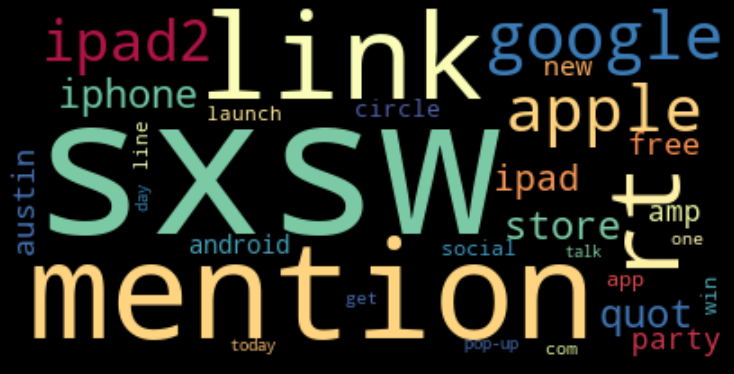

In [47]:
data_pos = df_full.loc[df_full['vs_pos'] >= 0.5,'tweet_original']
word_count_func(data_pos)

Overall vocab of subset: 220
30 most common words in subset:
[('sxsw', 37), ('mention', 32), ('link', 23), ('rt', 13), ('apple', 11), ('iphone', 6), ('store', 6), ('ipad2', 6), ('google', 5), ('austin', 4), ('launch', 4), ('app', 4), ('line', 4), ('today', 3), ('tomorrow', 3), ("i've", 3), ('ipad', 3), ('yes', 3), ('new', 3), ('android', 3), ('party', 3), ('thanks', 2), ('great', 2), ('see', 2), ('talk', 2), ('meeting', 2), ('11', 2), ('congrats', 2), ('awesome', 2), ('experience', 2)]
Word 		 Normalized Frequency

sxsw 		 0.09113
mention 		 0.07882
link 		 0.05665
rt 		 0.03202
apple 		 0.02709
iphone 		 0.01478
store 		 0.01478
ipad2 		 0.01478
google 		 0.01232
austin 		 0.009852
launch 		 0.009852
app 		 0.009852
line 		 0.009852
today 		 0.007389
tomorrow 		 0.007389
i've 		 0.007389
ipad 		 0.007389
yes 		 0.007389
new 		 0.007389
android 		 0.007389
party 		 0.007389
thanks 		 0.004926
great 		 0.004926
see 		 0.004926
talk 		 0.004926
meeting 		 0.004926
11 		 0.004926
congrats

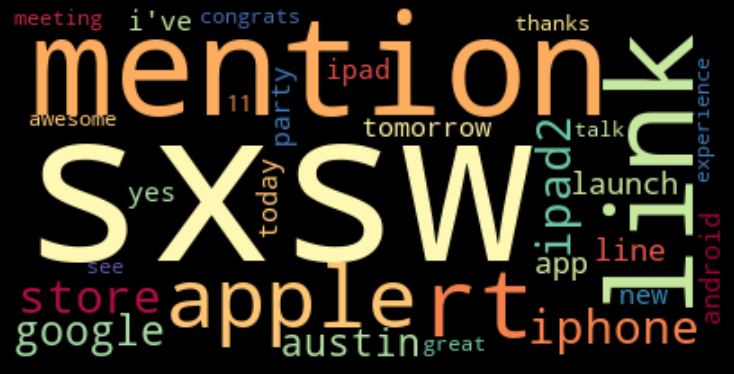

In [48]:
data_pos2 = df_full.loc[df_full['vs_pos'] >= 0.6 ,'tweet_original']
word_count_func(data_pos2)

## Summary 
More info with the valence categries:
* Overall - assuming SXSW and mention were used in all tweets about the festival
* negative >= 0.5.  Looks like people were complaining about hotspots/internet, check-in, tool/mobile(maybe the mobile site or another tool), restaurants, experimenting/tinkering (I think they wanted to play with the toys and didn't get to).  "viewed, explorer and mayer" were highly frequent.  Unsure what these refer to.
* positive >= 0.6.  'Link' and 'rt' are high - assuming people are linking to or retweeting new products they like.  I would infer general excitment for the various products from "being in 'line' 'today'/'tomorrow' 'launch' and the product names". And general thanks/congrats for "seeing/meeting" someone potentially at a 'party'


## Creating termite plot overall and by products and valence<a id="termite"></a>
##### [(back to top)](#EDA)

In [52]:
def termite_word_count_func(data):
    #using the process_tweet function to tokenize, lower and remove stopwords
    process_data = list(map(process_tweet, data))
    
    #lemmatizing words
    from nltk.stem import WordNetLemmatizer 
      
    #instantiating
    lemmatizer = WordNetLemmatizer() 

    #process_data is a list of lists - here looping over the lists and then the words in the list
    lemmatizer_tweets=[]
    for l in process_data:
        new_row = []
        for w in l:
            new_row.append(lemmatizer.lemmatize(w))
        lemmatizer_tweets.append(new_row)   
    
    #This is more descriptive info - calculating the unique vocab of the subset
    overall_lem_vocab = set()
    for tweet in lemmatizer_tweets:
        overall_lem_vocab.update(tweet)
#     print(f'Overall vocab of subset: {len(overall_lem_vocab)}')

    #Flattening (going from a list of lists to one single list) the lemmatized tweets for freq
    flat_lemmatizer_tweets = [item for sublist in lemmatizer_tweets for item in sublist]
    
    #applying nltk freqdist function to the flat list
    lem_freq = FreqDist(flat_lemmatizer_tweets)
#     print('30 most common words in subset:')
#     print(lem_freq.most_common(30))
    
    #returning normalized word freq because there are different N's
    total_words = sum(lem_freq.values())
    top_30 = lem_freq.most_common(30)
#     print("Word \t\t Normalized Frequency")
#     print()
    top_30_words = []
    for word in top_30:
        normalized_frequency = word[1]/total_words
        top_30_words.append((word[0], normalized_frequency))
    return top_30_words

In [115]:
#convert tuple to dictionary
def Convert(tup):
    di = {}
    for a, b in tup:
        di.setdefault(a, []).append(b)
    return di

### Create tuples for overall, apple, google, android, pos and neg labels

In [116]:
#Getting tuple of normalized word frequency on full dataste
data1 = df_full['tweet_original']
main_tuple = termite_word_count_func(data1)

In [117]:
data_apple = df_full.loc[df_full['product_agg']=='Apple','tweet_original']
apple_tuple = termite_word_count_func(data_apple)

In [118]:
data_google = df_full.loc[df_full['product_agg']=='Google','tweet_original']
google_tuple = termite_word_count_func(data_google)

In [119]:
data_android = df_full.loc[df_full['product_agg']=='Android','tweet_original']
android_tuple = termite_word_count_func(data_android)

In [120]:
data_neg = df_full.loc[df_full['emotion']==0,'tweet_original']
neg_tuple = termite_word_count_func(data_neg)

In [121]:
data_pos = df_full.loc[df_full['emotion']==1,'tweet_original']
pos_tuple = termite_word_count_func(data_pos)

In [122]:
tuples_list = [main_tuple,apple_tuple,google_tuple,android_tuple,neg_tuple,pos_tuple]


In [126]:
#Converting tuple to dictionary
dict_list = []
for tuple_ in tuples_list:
    x = Convert(tuple_)
    dict_list.append(x)
# main_tuple_dict = Convert(main_tuple)
# apple_tuple_dict = Convert(apple_tuple)
# google_tuple_dict = Convert(google_tuple)
# android_tuple_dict = Convert(android_tuple)
# negative_tuple_dict = Convert(neg_tuple)
# positive_tuple_dict = Convert(pos_tuple)
# dict_list.append(main_tuple_dict)

In [130]:
dict_list[0]['sxsw'][0]

0.08633449333225426

In [139]:
overall_new = []
for i in range(len(dict_list)):
    new_dict_list = {}
    for key, value in dict_list[i].items():
        new_dict_list[key] = value[0]
    overall_new.append(new_dict_list)
overall_new

[{'sxsw': 0.08633449333225426,
  'mention': 0.06406071560243509,
  'link': 0.03887345221074213,
  'rt': 0.026688967421115577,
  'google': 0.02216587085345347,
  'apple': 0.02005269452462525,
  'quot': 0.015250838526351758,
  'ipad': 0.014171769762694795,
  'iphone': 0.014126808564209087,
  'store': 0.013659212099957737,
  'ipad2': 0.012319368385083672,
  'new': 0.00980154126988409,
  'austin': 0.00861456562986143,
  'amp': 0.0075175123868101825,
  'app': 0.0073826287913530625,
  'launch': 0.0062136376307246844,
  'circle': 0.0062136376307246844,
  'social': 0.005835963563444747,
  'android': 0.0053323981404048305,
  'today': 0.005161545586159145,
  'network': 0.004262321616445008,
  'get': 0.004091469062199322,
  'line': 0.003992554425530767,
  'pop-up': 0.003794725152193657,
  'party': 0.0036058881185536884,
  'free': 0.0034799967627937092,
  'called': 0.0032461985306680334,
  'mobile': 0.003111314935210913,
  'sxswi': 0.0030753459764223477,
  'time': 0.002742633107628117},
 {'sxsw': 

In [140]:
termite_df = pd.DataFrame(overall_new)
termite_df

sxsw   mention      link        rt    google     apple      quot  \
0  0.086334  0.064061  0.038873  0.026689  0.022166  0.020053  0.015251   
1  0.088380  0.060837  0.037278  0.023697  0.017288  0.023004  0.014308   
2  0.083306  0.059615  0.036703  0.025581  0.037148  0.014014  0.018129   
3  0.086055  0.065319  0.034733  0.020736  0.019699  0.017107  0.012960   
4  0.087652  0.057994  0.036852  0.019380  0.022757  0.019380  0.016444   
5  0.086834  0.062016  0.036729  0.025453  0.021750  0.021087  0.015172   

       ipad    iphone     store  ...     mayer   marissa    people     check  \
0  0.014172  0.014127  0.013659  ...       NaN       NaN       NaN       NaN   
1  0.016699  0.015833  0.015071  ...       NaN       NaN       NaN       NaN   
2  0.013013  0.011122  0.010010  ...  0.004338  0.003893       NaN       NaN   
3  0.013997  0.017626  0.009850  ...       NaN       NaN  0.003629  0.003629   
4  0.018499  0.017031  0.013067  ...       NaN       NaN       NaN       NaN   
5  0.014841  0.014343  0.013984  ...       NaN       NaN       NaN       NaN   

   awesome      apps    think     love     team     need  
0      NaN       NaN      NaN      NaN      NaN      NaN  
1      NaN       NaN      NaN      NaN      NaN      NaN  
2      NaN       NaN      NaN      NaN      NaN      NaN  
3  0.00311  0.003110  0.00311  0.00311  0.00311      NaN  
4      NaN  0.003083      NaN      NaN      NaN  0.00279  
5      NaN       NaN      NaN      NaN      NaN      NaN  

[6 rows x 46 columns]

In [141]:
termite_df.fillna(0,inplace=True)

In [145]:
transpose_termite_df = termite_df.T

In [148]:
transpose_termite_df.rename(columns={0:'Overall',
                                     1:'Apple',
                                    2:'Google',
                                    3:'Android',
                                    4:'Negative',
                                    5:'Positive'}, inplace=True)

In [149]:
transpose_termite_df

Overall     Apple    Google   Android  Negative  Positive
sxsw       0.086334  0.088380  0.083306  0.086055  0.087652  0.086834
mention    0.064061  0.060837  0.059615  0.065319  0.057994  0.062016
link       0.038873  0.037278  0.036703  0.034733  0.036852  0.036729
rt         0.026689  0.023697  0.025581  0.020736  0.019380  0.025453
google     0.022166  0.017288  0.037148  0.019699  0.022757  0.021750
apple      0.020053  0.023004  0.014014  0.017107  0.019380  0.021087
quot       0.015251  0.014308  0.018129  0.012960  0.016444  0.015172
ipad       0.014172  0.016699  0.013013  0.013997  0.018499  0.014841
iphone     0.014127  0.015833  0.011122  0.017626  0.017031  0.014343
store      0.013659  0.015071  0.010010  0.009850  0.013067  0.013984
ipad2      0.012319  0.014551  0.007563  0.005184  0.012186  0.012740
new        0.009802  0.007968  0.011790  0.009331  0.008809  0.009065
austin     0.008615  0.009320  0.007007  0.008294  0.008516  0.008429
amp        0.007518  0.006652  0.009009  0.007776  0.007194  0.007545
app        0.007383  0.008696  0.006562  0.015552  0.007194  0.008678
launch     0.006214  0.004053  0.007897  0.003629  0.004551  0.005196
circle     0.006214  0.003361  0.009788  0.004147  0.005139  0.005113
social     0.005836  0.003534  0.009120  0.000000  0.005286  0.004892
android    0.005332  0.005405  0.000000  0.016071  0.005286  0.005279
today      0.005162  0.003915  0.006117  0.006221  0.004992  0.004477
network    0.004262  0.000000  0.007229  0.000000  0.003230  0.003537
get        0.004091  0.004400  0.003559  0.004147  0.003230  0.004367
line       0.003993  0.004539  0.003893  0.000000  0.005139  0.004173
pop-up     0.003795  0.004331  0.000000  0.004666  0.003377  0.003980
party      0.003606  0.003465  0.004783  0.004666  0.002790  0.004007
free       0.003480  0.003915  0.000000  0.003629  0.003230  0.003565
called     0.003246  0.000000  0.005450  0.000000  0.000000  0.000000
mobile     0.003111  0.000000  0.005561  0.000000  0.000000  0.003178
sxswi      0.003075  0.000000  0.003337  0.000000  0.000000  0.000000
time       0.002743  0.003049  0.000000  0.000000  0.000000  0.003151
like       0.000000  0.003395  0.000000  0.000000  0.006020  0.000000
win        0.000000  0.003049  0.000000  0.000000  0.000000  0.000000
one        0.000000  0.003014  0.000000  0.000000  0.003083  0.002847
temporary  0.000000  0.002737  0.000000  0.000000  0.000000  0.000000
map        0.000000  0.000000  0.005116  0.000000  0.000000  0.002902
major      0.000000  0.000000  0.005005  0.000000  0.000000  0.000000
mayer      0.000000  0.000000  0.004338  0.000000  0.000000  0.000000
marissa    0.000000  0.000000  0.003893  0.000000  0.000000  0.000000
people     0.000000  0.000000  0.000000  0.003629  0.000000  0.000000
check      0.000000  0.000000  0.000000  0.003629  0.000000  0.000000
awesome    0.000000  0.000000  0.000000  0.003110  0.000000  0.000000
apps       0.000000  0.000000  0.000000  0.003110  0.003083  0.000000
think      0.000000  0.000000  0.000000  0.003110  0.000000  0.000000
love       0.000000  0.000000  0.000000  0.003110  0.000000  0.000000
team       0.000000  0.000000  0.000000  0.003110  0.000000  0.000000
need       0.000000  0.000000  0.000000  0.000000  0.002790  0.000000

In [150]:
mat = transpose_termite_df.to_numpy()

In [151]:
mat

array([[0.08633449, 0.08837999, 0.08330553, 0.08605495, 0.08765233,
        0.08683396],
       [0.06406072, 0.06083703, 0.05961517, 0.06531882, 0.05799442,
        0.06201636],
       [0.03887345, 0.03727827, 0.03670337, 0.03473302, 0.03685215,
        0.03672894],
       [0.02668897, 0.02369734, 0.02558114, 0.02073613, 0.01938041,
        0.02545324],
       [0.02216587, 0.01728797, 0.03714826, 0.01969933, 0.0227573 ,
        0.02174994],
       [0.02005269, 0.02300443, 0.01401401, 0.01710731, 0.01938041,
        0.02108667],
       [0.01525084, 0.01430848, 0.01812924, 0.01296008, 0.01644399,
        0.01517245],
       [0.01417177, 0.016699  , 0.01301301, 0.01399689, 0.01849949,
        0.01484081],
       [0.01412681, 0.01583287, 0.01112223, 0.01762571, 0.01703127,
        0.01434336],
       [0.01365921, 0.01507068, 0.01001001, 0.00984966, 0.0130671 ,
        0.01398408],
       [0.01231937, 0.014551  , 0.00756312, 0.00518403, 0.01218617,
        0.01274044],
       [0.00980154, 0

In [159]:
col_names = list(transpose_termite_df.columns)

In [158]:
words = list(transpose_termite_df.index)

In [162]:
from textacy.viz.termite import draw_termite_plot

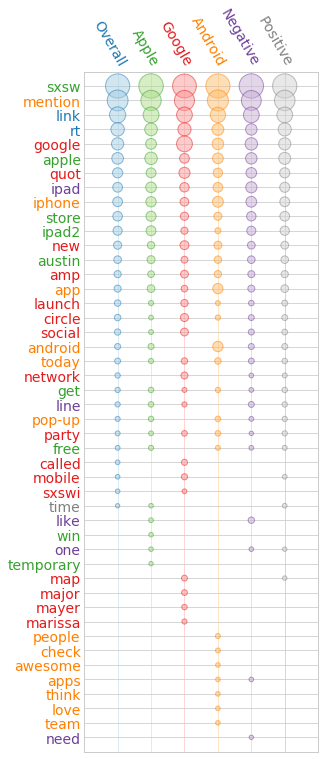

In [163]:
draw_termite_plot(mat,col_names,words,highlight_cols=range(0,5))
